In [99]:
import numpy as np
import pandas as pd

import itertools
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures

from matplotlib import pyplot as plt
import matplotlib.animation as animation
import seaborn
# %matplotlib inline

from IPython.display import HTML

In [7]:
class Perceptron(object):
    def __init__(self, learning_rate, max_iter = 1000):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
    
    def predict(self, X):
        X = np.hstack([np.ones((X.shape[0], 1)), np.array(X)])
        return np.array([self._predict_one(v) for v in X])
    
    def _predict_one(self, x):
        return int(np.dot(self.weights.T, x) >= 0)
    
    def fit(self, X, y, verbose = False):
        X = np.hstack([np.ones((X.shape[0], 1)), np.array(X)])
        y = np.array(y)
        
        n = X.shape[0]
        
        if self.max_iter < n:
            self.max_iter = n
                   
        self.weights = np.random.normal(size=X.shape[1])
        
        best_weights = self.weights.copy()
        best_score = 0.
        
        for i in range(self.max_iter):
            idx = i % n
            pred = self._predict_one(X[idx])
            if pred != y[idx]:
                if pred == 0:
                    self.weights += self.learning_rate*X[idx]
                else:
                    self.weights -= self.learning_rate*X[idx]
                    
            cur_score = accuracy_score(y, [self._predict_one(v) for v in X])
                
            if cur_score > best_score:
                best_score = cur_score
                best_weights = self.weights.copy()
                
            if verbose and i % (self.max_iter/10) == 0:
                print 'iteration: {}, accuracy:{}'.format(i, best_score)
        
        if verbose:
            print 'best score: {}'.format(best_score)
            print 'best weights: {}'.format(best_weights)
            
        self.weights = best_weights
        return best_score

In [8]:
data = pd.read_csv('data/blobs2.csv')

In [9]:
X = data.drop(['label'], axis=1)
y = data['label']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75)

In [11]:
model = Perceptron(learning_rate=0.5, max_iter=10000)
model.fit(X_train, y_train, verbose = True)

iteration: 0, accuracy:0.874666666667
iteration: 1000, accuracy:0.978666666667
iteration: 2000, accuracy:0.982666666667
iteration: 3000, accuracy:0.985333333333
iteration: 4000, accuracy:0.985333333333
iteration: 5000, accuracy:0.985333333333
iteration: 6000, accuracy:0.985333333333
iteration: 7000, accuracy:0.985333333333
iteration: 8000, accuracy:0.986666666667
iteration: 9000, accuracy:0.986666666667
best score: 0.986666666667
best weights: [ 14.41513591   0.89071795  -5.75716283]


0.98666666666666669

In [12]:
preds = model.predict(X_test)
print accuracy_score(y_test, preds)

0.98


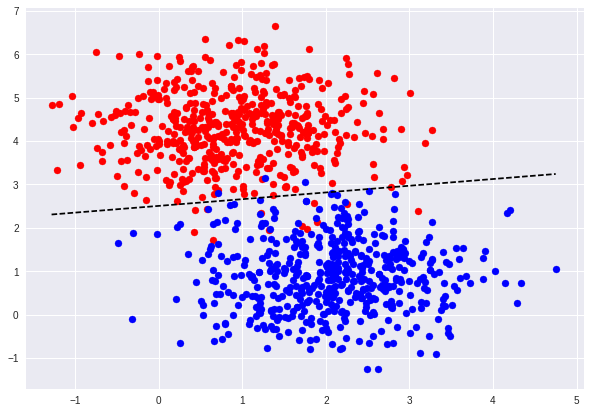

In [13]:
plt.figure(figsize=(10, 7))
plt.scatter(data[data['label'] == 0]['x'], data[data['label'] == 0]['y'], color='red')
plt.scatter(data[data['label'] == 1]['x'], data[data['label'] == 1]['y'], color='blue')
a, b = -model.weights[1]/model.weights[2], -model.weights[0]/model.weights[2]
l = np.linspace(np.min(data['x']), np.max(data['x']))
plt.plot(l, a*l+b, 'k--')

In [14]:
def plot_polynomial(X_orig, y_train, k):
    x_min, x_max = np.min(X_orig['x']) - 1, np.max(X_orig['x']) + 1
    y_min, y_max = np.min(X_orig['y']) - 1, np.max(X_orig['y']) + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.025),
                         np.arange(y_min, y_max, 0.025))
    
    X_test = np.c_[xx.ravel(), yy.ravel()]
    
    poly = PolynomialFeatures(degree=k)
    X_train = poly.fit_transform(X_orig)
    X_test = poly.transform(X_test)
    
    model = Perceptron(learning_rate=0.5)
    score = model.fit(X_train, y_train)
    Z = model.predict(X_test)
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(10, 7))
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X_orig[y_train == 0]['x'], X_orig[y_train == 0]['y'], color='red')
    plt.scatter(X_orig[y_train == 1]['x'], X_orig[y_train == 1]['y'], color='blue')
    plt.title('degree: {}, accuracy: {}'.format(k, score))
    
    print 'model weights: {}'.format(model.weights)
        

model weights: [ 12.83473556  11.12069356  10.1943646   18.60408827  10.27357845
   9.72265613  22.25548176  14.94623005  -1.39111733  -8.16465429
 -14.52418817]


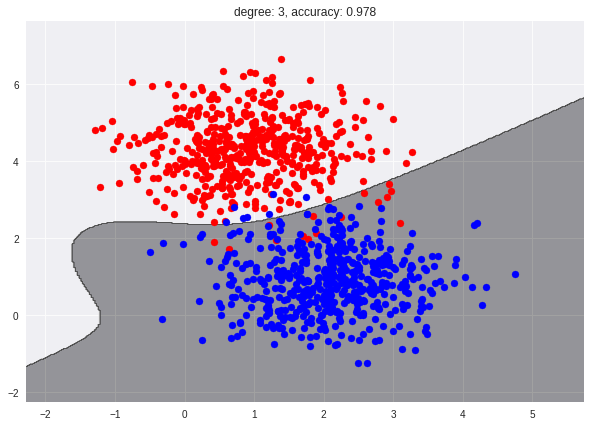

In [15]:
plot_polynomial(X, y, 3)

model weights: [  19.93374069   20.07262275   21.87362754   39.25266179   31.28285264
   39.80648212   66.11145954   51.17540457   53.46047542   65.38672571
   82.30933671   90.26375893   57.85694836   63.94338113   55.34439429
 -151.33684196]


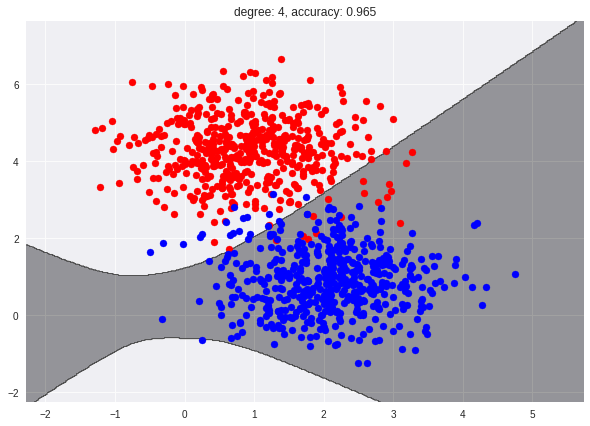

In [16]:
plot_polynomial(X, y, 4)

model weights: [  17.60740345   17.95228633   19.2028889    31.37661975   31.25369128
   31.33008257   52.97276039   50.02190249   41.76807634   51.28573733
   86.63718295  103.07521534   55.67916181   47.955327     62.25930497
   91.21489579  246.55425335   69.73130437   -4.30487726  -17.74383172
   -5.59413164 -126.87674607]


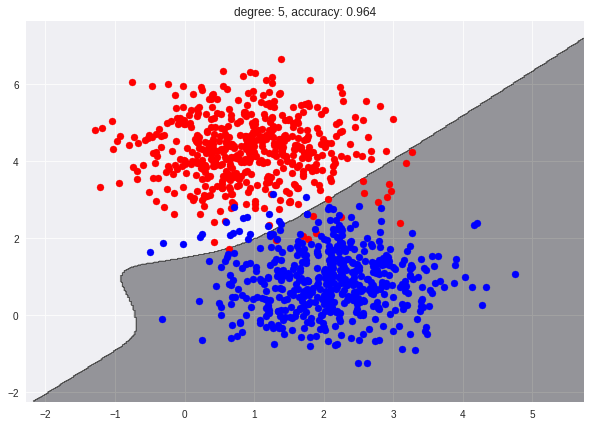

In [17]:
plot_polynomial(X, y, 5)

In [108]:
class PerceptronWithAnimation(Perceptron):
    def __init__(self, X, y, max_iter = 1000, learning_rate = 1.):
        self.learning_rate = learning_rate
        self.iter = 0
        self.X = np.hstack([np.ones((X.shape[0], 1)), np.array(X)])
        self.y = np.array(y)
        self.n = X.shape[0]
        self.max_iter = max_iter
        self.weights = np.random.normal(size=self.X.shape[1])
        self.best_weights = None
        self.best_score = 0.
        self.done = False
        
    def _iterate(self):
        if self.iter >= self.max_iter:
            self.done = True
            return
        
        idx = self.iter % self.n
        pred = self._predict_one(self.X[idx])
        
        if pred != self.y[idx]:
            if pred == 0:
                self.weights += self.learning_rate*self.X[idx]
            else:
                self.weights -= self.learning_rate*self.X[idx]
            
        cur_score = accuracy_score(self.y, [self._predict_one(v) for v in self.X])
        
        if cur_score > self.best_score:
            self.best_score = cur_score
            self.best_weights = self.weights.copy()
            
        if self.iter % 100 == 0:
            self.plot()
            
        self.iter += 1
    
    def plot(self):
        plt.clf()
        plt.scatter(self.X[self.y == 0][:,1], self.X[self.y == 0][:,2], color='red')
        plt.scatter(self.X[self.y == 1][:,1], self.X[self.y == 1][:,2], color='blue')
        a, b = -self.best_weights[1]/self.best_weights[2], -self.best_weights[0]/self.best_weights[2]
        l = np.linspace(np.min(self.X[:,1]), np.max(self.X[:,1]))
        plt.plot(l, a*l+b, 'k--')
        plt.title('accuracy: {}'.format(self.best_score))
    
    def predict(self, X):
        X = np.hstack([np.ones((X.shape[0], 1)), np.array(X)])
        return np.array([self._predict_one(v) for v in X])
    
    def _predict_one(self, x):
        return int(np.dot(self.weights.T, x) >= 0)

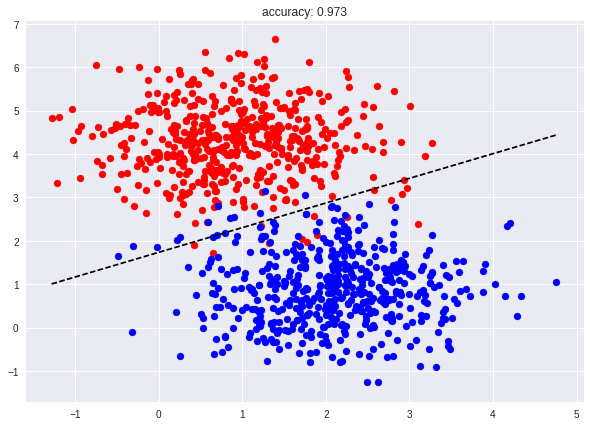

In [111]:
p = PerceptronWithAnimation(X, y, 1000, 0.5)
fig = plt.figure(figsize=(10, 7))
plt.ylim(np.min(X['y']) - 1, np.max(X['y'])+1)
plt.xlim(np.min(X['x']) - 1, np.max(X['x'])+1)

def animate(i):
    p._iterate()
    
def g(repeats = 3):
    while not p.done:
        yield True
    for _ in range(0,repeats):
        yield True
        
ani = animation.FuncAnimation(fig, animate, frames = g(6), interval = 100, save_count = 1000
HTML(ani.to_html5_video())